# Classifying MNIST by Pretrained CNN

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

from tqdm import tqdm

In [2]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Hyper-Param.

In [3]:
# epoch
epochs = 1

# batch_size
m = 150

# learning_rate
lr = 0.0001


## 데이터 셋 로드

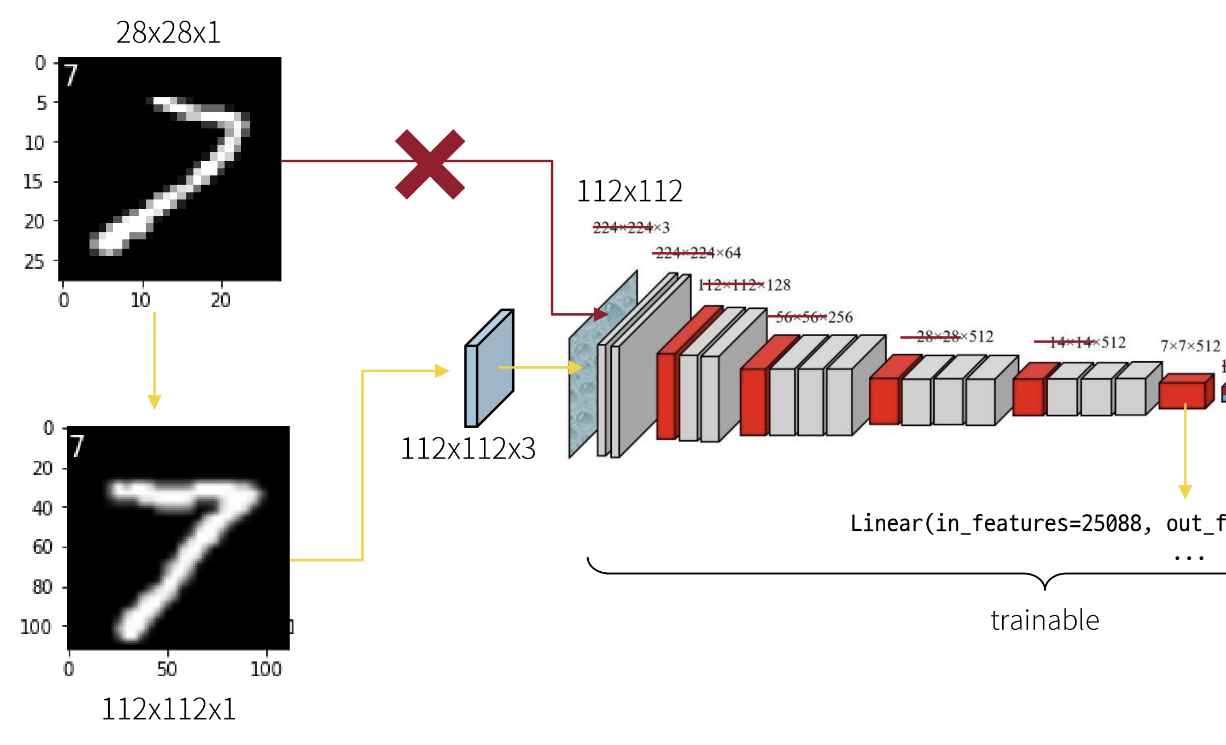

In [5]:
# 이미지 오그먼테이션 정의 [+]
trfms = T.Compose([
        T.ToTensor(),
        T.Resize((112,112), antialias=True)
    ])
# 기존 28*28은 conv과정을 거치면서 사이즈가 급격히 작아지므로
# 112*112로 사이즈를 키워주는 작업

In [6]:
download = not os.path.exists("./data")

D_train = torchvision.datasets.MNIST(
    root='./data', # 데이터 저장 위치
    train=True, # True: train set, False: test set
    transform=trfms,
    download=download # 다운로드 여부, (이미 다운받았으면 False로 지정)
)

D_test = torchvision.datasets.MNIST(
    root='./data', # 데이터 저장 위치
    train=False, # True: train set, False: test set
    transform=trfms,
    download=download # 다운로드 여부, (이미 다운받았으면 False로 지정)
)

100%|██████████| 9912422/9912422 [00:00<00:00, 233084291.50it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30582098.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 76785222.24it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20137979.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
print("# of Train Set:", len(D_train))
print("# of Test Set:", len(D_test))

# of Train Set: 60000
# of Test Set: 10000


## 데이터 로더

In [8]:
train_loader = torch.utils.data.DataLoader(D_train, batch_size=m, shuffle=True,
                                           num_workers=2, pin_memory=True)

test_loader = torch.utils.data.DataLoader(D_test, batch_size=m, shuffle=True,
                                           num_workers=2, pin_memory=True)

## 데이터 확인

In [9]:
train_loader_iter = iter(train_loader)
X_batched, y_batched = next(train_loader_iter)

In [10]:
print(X_batched.shape)
print(y_batched.shape)

torch.Size([150, 1, 112, 112])
torch.Size([150])


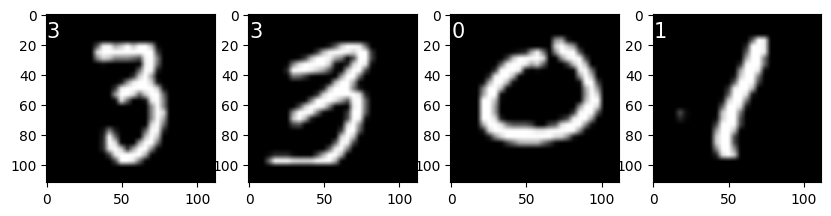

In [11]:
# 4개만 가져와서 그림 그리기
X = X_batched[:4]
y = y_batched[:4]

fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=4)

for i in range(4):
    ax[i].imshow(X[i][0], cmap='gray')
    ax[i].text(0, 15, y[i].item(), color='w', fontsize=15)
plt.show()

## Define Model

In [13]:
# pretrained 모델을 만들고
vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
vgg16
# classifier를 교체 한다.[+]
# 원래 vgg16 끝에 분류기 입력 피쳐 개수
in_features = vgg16.classifier[0].in_features

# 새로운 분류기를 시퀀셜 모델로 만들고
clf = torch.nn.Sequential(
        torch.nn.Linear(in_features=in_features, out_features=256), # (N,10)
        torch.nn.BatchNorm1d(256),
        torch.nn.ReLU(),
        torch.nn.Dropout(),
        torch.nn.Linear(in_features=256, out_features=10), # (N,10)
        torch.nn.LogSoftmax(dim=-1)
            )
# 교체해버림
vgg16.classifier = clf

# MNIST는 흑백이미지라 이미지 채널이 1
# vgg16은 첫 입력을 채널이 3이므로
# 이미지의 채널을 3으로 만들기 위해  1->3인 1x1 conv 추가하고
# 뒤이어 바로 vgg16을 배치
# 최종 모델을 만든다.[+]
model = torch.nn.Sequential(
    # 첫입력을 채널3으로 만들기 위해 1->3인 1x1 conv 추가[+]
    torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1),
    # kernel_size=1 이므로 같은 이미지 3장인 3채널 생성
    vgg16
)

In [14]:
# 모델 구조 출력
model

Sequential(
  (0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (1): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [15]:
# 포워드 테스트
out = model(torch.rand(2,1,112,112))
out.shape

torch.Size([2, 10])

## Loss func. and Optimizer

In [16]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Train

In [17]:
model.to(device)

start = time.time()  # 시작 시간 저장

for e in range(epochs):
    model.train()
    # tqdm : 그래프를 그려줌 (from tqdm import tqdm)
    for i, d in enumerate(tqdm(train_loader)):
        X = d[0].to(device)
        y = d[1].to(device)

        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    # train, test loss and acc.
    model.eval()
    with torch.no_grad():
        corr = 0
        loss_sum = 0.0
        for j, d in enumerate(train_loader):
            X = d[0].to(device)
            y = d[1].to(device)
            out = model(X) # (N, 10) # log softmax
            loss = criterion(out, y)
            loss_sum += loss
            y_pred = torch.argmax(torch.exp(out), dim=-1)
            corr += ((y == y_pred).cpu().numpy().astype(int)).sum()
        train_acc = corr / len(D_train)
        train_loss = loss_sum / (j+1)

        corr = 0
        loss_sum = 0.0
        for j, d in enumerate(test_loader):
            X = d[0].to(device)
            y = d[1].to(device)
            out = model(X) # (N, 10) # log softmax
            loss = criterion(out, y)
            loss_sum += loss
            y_pred = torch.argmax(torch.exp(out), dim=-1)
            corr += ((y == y_pred).cpu().numpy().astype(int)).sum()
        test_acc = corr / len(D_test)
        test_loss = loss_sum / (j+1)

    print(f"EPOCH:{e+1:3d}, Train Loss:{train_loss:.6f}, Train Acc.:{train_acc:.6f}, Test Loss:{test_loss:.6f}, Test Acc.:{test_acc:.6f}")

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

100%|██████████| 400/400 [03:30<00:00,  1.90it/s]


EPOCH:  1, Train Loss:0.024850, Train Acc.:0.995817, Test Loss:0.031787, Test Acc.:0.993100
time : 295.03475546836853
